In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from mlxtend.regressor import StackingRegressor
import warnings
warnings.filterwarnings('ignore')

### Loading data

In [2]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    y = y - np.mean(y)
    X = np.array([experiment - np.max(experiment) for experiment in X])
    X = np.array([experiment/-np.min(experiment) for experiment in X])

    return X, y

def get_freq_data(X, freq=20, start_point=355):
    X_freq = np.concatenate([X[:, start_point::-freq][:,::-1], X[:, start_point+freq::freq]], axis=1)
    return X_freq

In [3]:
X, y = get_data()

In [4]:
huber_reg = HuberRegressor(epsilon= 5.09, alpha= 0.0004)
ridge_reg = linear_model.Ridge(solver='saga', max_iter=4000, alpha= 0.582)
lasso_reg = linear_model.Lasso(max_iter=4000, alpha=0.0038, normalize=False)
dt_reg = tree.DecisionTreeRegressor(min_samples_split=7, min_samples_leaf=7, min_weight_fraction_leaf=0.000516, 
                                                                                             max_features='auto')   
xgb_reg = xgb.XGBRegressor(objective="reg:linear", alpha= 0.00244, booster='dart', eta= 0.017326, gamma=0.19504, 
                           reg_lambda=0.22451, max_depth=8, verbosity=0)

In [5]:
models = [huber_reg, ridge_reg, lasso_reg, dt_reg,  xgb_reg]

### Let's find out how scores depend on frequency of sampling

In [6]:
metric_names = ['R2 score', 'MAE', 'MSE', 'RMSE']

In [7]:
models_scores = {type(model).__name__:{metric_name:[] for metric_name in metric_names} for model in models}

In [8]:
models_scores

{'HuberRegressor': {'R2 score': [], 'MAE': [], 'MSE': [], 'RMSE': []},
 'Ridge': {'R2 score': [], 'MAE': [], 'MSE': [], 'RMSE': []},
 'Lasso': {'R2 score': [], 'MAE': [], 'MSE': [], 'RMSE': []},
 'DecisionTreeRegressor': {'R2 score': [], 'MAE': [], 'MSE': [], 'RMSE': []},
 'XGBRegressor': {'R2 score': [], 'MAE': [], 'MSE': [], 'RMSE': []}}

In [9]:
[1] + list(range(10, 70, 10))

[1, 10, 20, 30, 40, 50, 60]

In [10]:
TIME_SCALE_COEF = 0.2
freq_range = [1] + list(range(10, 60, 10))

for freq in freq_range:
    print("Frequency:", freq)
    X, y = get_data()
    X = get_freq_data(X, freq=freq)
    for model in models:    
        model_name = type(model).__name__
        print("Model:", model_name)
        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X, y, scoring=scoring, cv=5)
 
        r2_score_mean = scores['test_r2'].mean()
        r2_score_std = scores['test_r2'].std()
        mse_score_mean = TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean()
        mse_score_std = TIME_SCALE_COEF * scores['test_neg_mean_squared_error'].std()
        mae_score_mean = TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean()
        mae_score_std = TIME_SCALE_COEF * scores['test_neg_mean_absolute_error'].std()
        rmse_score_mean = TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean()
        rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error'] * TIME_SCALE_COEF**2).std()
        
        cur_scores = [(r2_score_mean, r2_score_std), (mae_score_mean, mae_score_std),\
                      (mse_score_mean, mse_score_std), (rmse_score_mean, rmse_score_std)]
#         print('!!!!!!!!')
#         print("TEST")
#         print(models_scores[type(models[0]).__name__]['r2'])
#         print('!!!!!!!!')
        print("95% confidence interval:")
        for i, metric in enumerate(metric_names, 0):
            models_scores[model_name][metric].append(cur_scores[i])
            print(metric, ": %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
        print('----------------------------------')
    print('____________________________________________________________')
    print()

Frequency: 1
Model: HuberRegressor
95% confidence interval:
R2 score : 0.99966 (+/- 0.00001)
MAE : 0.03703 (+/- 0.00119)
MSE : 0.00220 (+/- 0.00050)
RMSE : 0.04688 (+/- 0.00106)
----------------------------------
Model: Ridge
95% confidence interval:
R2 score : 0.99967 (+/- 0.00000)
MAE : 0.03625 (+/- 0.00132)
MSE : 0.00213 (+/- 0.00062)
RMSE : 0.04616 (+/- 0.00134)
----------------------------------
Model: Lasso
95% confidence interval:
R2 score : 0.99921 (+/- 0.00009)
MAE : 0.05270 (+/- 0.00279)
MSE : 0.00515 (+/- 0.00379)
RMSE : 0.07172 (+/- 0.00529)
----------------------------------
Model: DecisionTreeRegressor
95% confidence interval:
R2 score : 0.99931 (+/- 0.00006)
MAE : 0.05308 (+/- 0.00101)
MSE : 0.00451 (+/- 0.00073)
RMSE : 0.06718 (+/- 0.00110)
----------------------------------
Model: XGBRegressor
95% confidence interval:
R2 score : 0.99967 (+/- 0.00003)
MAE : 0.03665 (+/- 0.00049)
MSE : 0.00217 (+/- 0.00042)
RMSE : 0.04661 (+/- 0.00090)
----------------------------------


### Save our results

In [11]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [12]:
save_obj(models_scores, 'models_scores')

array([[0.04661291, 0.00044964],
       [0.04888413, 0.00074133],
       [0.05004542, 0.0007063 ],
       [0.05601899, 0.00099917],
       [0.06370864, 0.0005952 ],
       [0.07044284, 0.00155526]])

In [53]:
import pandas as pd
data1 = pd.Series(np.array(models_scores['XGBRegressor']['RMSE'])[:, 0])
data1.index= [0, 10, 20, 30, 40, 50]

data2 = pd.Series(np.array(models_scores['Lasso']['RMSE'])[:, 0])
data2.index= [0, 10, 20, 30, 40, 50]

In [49]:
data1

1     0.046613
10    0.048884
20    0.050045
30    0.056019
40    0.063709
50    0.070443
dtype: float64

In [38]:
data.index= [1, 10, 20,]

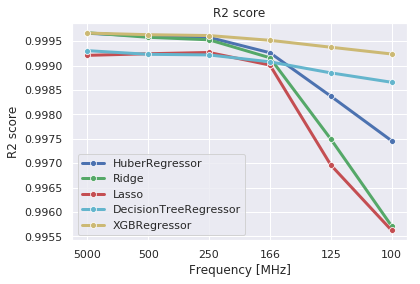

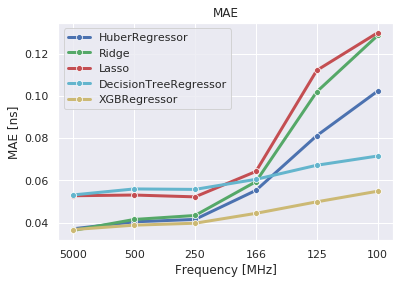

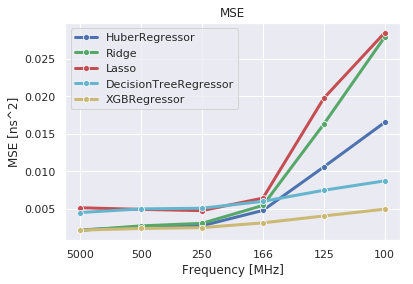

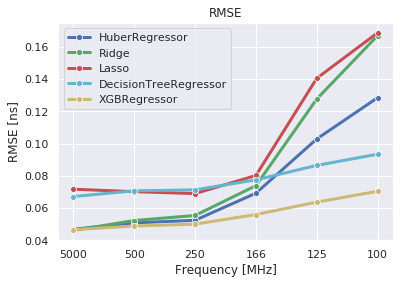

In [80]:
import seaborn as sns; sns.set()

ORIGIN_FREQ = 5000
colors = ['b', 'g', 'r', 'c', 'y', 'k']

for metric in metric_names:
    for i in range(len(models)):
        plt.title(metric)
        plt.ylabel(metric + (metric != 'R2 score' and metric != 'MSE')*' [ns]' + (metric=='MSE')*' [ns^2]')
        plt.xlabel('Frequency [MHz]')
        plt.xticks([i for i in range(0, len(freq_range))], [int(ORIGIN_FREQ/freq) for freq in freq_range])
        data = pd.Series(np.array(models_scores[type(models[i]).__name__][metric])[:, 0])
        sns.lineplot(data=data, color = colors[i], linewidth=3, style='logic', marker='o')
        
        plt.legend([type(model).__name__ for model in models])
    plt.show()

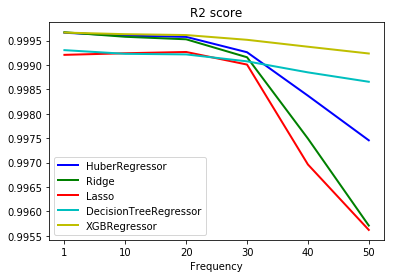

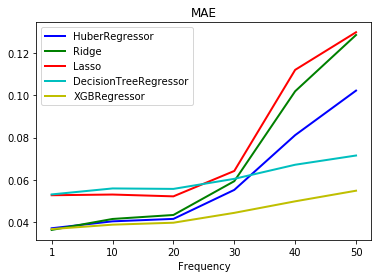

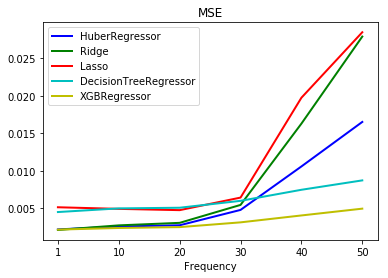

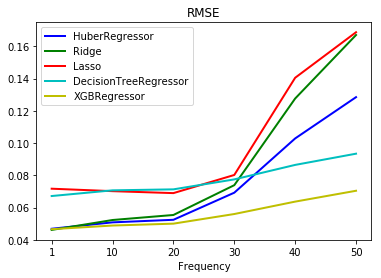

In [16]:
colors = ['b', 'g', 'r', 'c', 'y', 'k']

for metric in metric_names:
    for i in range(len(models)):
        plt.title(metric)
        plt.xlabel('Frequency')
        plt.plot(np.array(models_scores[type(models[i]).__name__][metric])[:, 0], color=colors[i], linewidth=2)
        plt.xticks([i for i in range(0, len(freq_range))], freq_range)
        plt.legend([type(model).__name__ for model in models])
    plt.show()